# Demand Forecast for Popcorn Holders

In [1]:
# import libraries
import itertools
import numpy as np
import pandas as pd
import datetime as dt
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from math import sqrt
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import data 
df = pd.read_csv('Subsample.csv', index_col=0)
df['Day'] = pd.to_datetime(df['Day']) 

# check 
display(df.head())
display(df.info())

,InvoiceNo,StockCode,Quantity,UnitPrice,CustomerID,Country,Description,Date,Day
219,536390,22197,100,0.72,17511.0,United Kingdom,POPCORN HOLDER,2010-12-01 10:19:00,2010-12-01
384,536404,22197,36,0.85,16218.0,United Kingdom,POPCORN HOLDER,2010-12-01 11:29:00,2010-12-01
523,536409,22197,2,0.85,17908.0,United Kingdom,POPCORN HOLDER,2010-12-01 11:45:00,2010-12-01
601,536412,22197,5,0.85,17920.0,United Kingdom,POPCORN HOLDER,2010-12-01 11:49:00,2010-12-01
794,536464,22197,5,0.85,17968.0,United Kingdom,POPCORN HOLDER,2010-12-01 12:23:00,2010-12-01


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1030 entries, 219 to 384568
Data columns (total 9 columns):
InvoiceNo      1030 non-null int64
StockCode      1030 non-null int64
Quantity       1030 non-null int64
UnitPrice      1030 non-null float64
CustomerID     1030 non-null float64
Country        1030 non-null object
Description    1030 non-null object
Date           1030 non-null object
Day            1030 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 80.5+ KB


None

## Step 1: 
* calculate total daily sales quantity for each country
* split data into train and test along time axis
* report raw # of obs by each country

In [3]:
# compute total daily sales quantity
df = df.groupby(['Day','Country'])['Quantity'].sum().reset_index(name ='DailySales')

# split data into train and test
test_start_date = '2011-11-27'
test_end_date   = '2011-12-03'
df_train = df[df.Day<test_start_date]
df_test  = df[(df.Day>=test_start_date) & (df.Day<=test_end_date)]

# report raw obs per country
df_obs = pd.DataFrame(df_train.groupby('Country')['DailySales'].agg(['count']))
print(df_obs)

                 count
Country               
Belgium              1
Channel Islands      2
Cyprus               1
EIRE                29
France              20
Germany             10
Israel               1
Italy                3
Netherlands          1
Norway               3
Singapore            3
Spain               11
Switzerland          1
United Kingdom     269


## Step 2:
* focus on the UK only
* create time-series features: weekday, month, quarter
* create time-series plots: daily and weekly

In [4]:
# create train data for UK
df_train_uk = df_train[df_train.Country=='United Kingdom']
df_train_uk = df_train_uk[['DailySales','Day']]
df_train_uk = df_train_uk.sort_values(by=['Day'])
df_train_uk = df_train_uk.set_index('Day')

# fillin days where no sales are made
idx = pd.date_range(df_train_uk.index.min(),'2011-11-26')
df_train_uk.index = pd.DatetimeIndex(df_train_uk.index)
df_train_uk = df_train_uk.reindex(idx, fill_value=0)
df_train_uk['date'] = df_train_uk.index

# create time series features
df_train_uk['Weekday'] = df_train_uk.index.weekday
df_train_uk['Month']   = df_train_uk.index.month
df_train_uk['Quarter'] = df_train_uk.index.quarter 

In [5]:
# summary stats of train data
display(df_train_uk.describe(include='all'))

,DailySales,date,Weekday,Month,Quarter
count,361.000000,361,361.000000,361.000000,361.000000
unique,NaN,361,NaN,NaN,NaN
top,NaN,2010-12-24 00:00:00,NaN,NaN,NaN
freq,NaN,1,NaN,NaN,NaN
first,NaN,2010-12-01 00:00:00,NaN,NaN,NaN
last,NaN,2011-11-26 00:00:00,NaN,NaN,NaN
mean,108.797784,NaN,3.005540,6.476454,2.493075
std,307.012270,NaN,1.995821,3.439174,1.113344
min,0.000000,NaN,0.000000,1.000000,1.000000
25%,0.000000,NaN,1.000000,4.000000,2.000000


In [6]:
# create test data for UK
df_test_uk = df_test[df_test.Country=='United Kingdom']
df_test_uk = df_test_uk[['DailySales','Day']]
df_test_uk = df_test_uk.sort_values(by=['Day'])
df_test_uk = df_test_uk.set_index('Day')

# fillin days where no sales are made
idx = pd.date_range(test_start_date, test_end_date)
df_test_uk.index = pd.DatetimeIndex(df_test_uk.index)
df_test_uk = df_test_uk.reindex(idx, fill_value=0)

# create time series features
df_test_uk['Weekday'] = df_test_uk.index.weekday
df_test_uk['Quarter'] = df_test_uk.index.quarter
df_test_uk['Month']   = df_test_uk.index.month

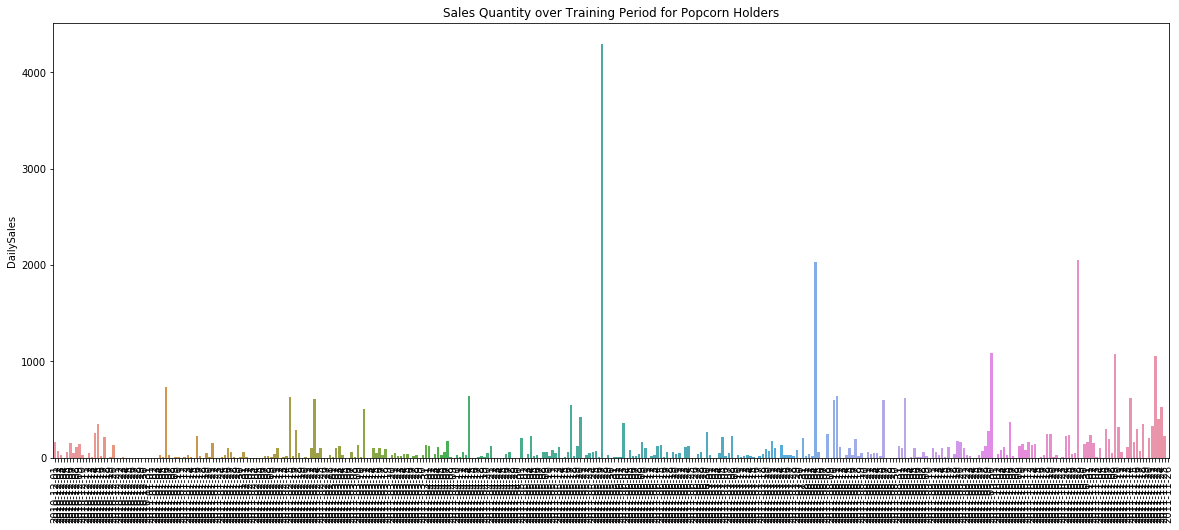

In [7]:
# plot daily sales
fig,ax = plt.subplots(figsize=(20,8)) 
fig = sns.barplot(x=df_train_uk.index, y='DailySales', data=df_train_uk)
x_dates = df_train_uk.index.strftime('%Y-%m-%d')
ax.set_xticklabels(labels=x_dates, rotation=90)
ax.set_title('Sales Quantity over Training Period for Popcorn Holders')
plt.show()

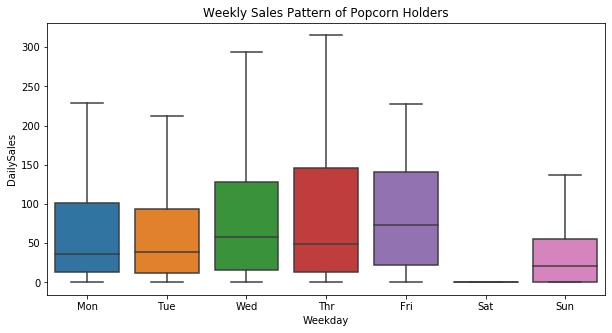

In [8]:
# plot weekly pattern
df_week = df_train_uk[['DailySales','Weekday']]
fig,ax = plt.subplots(figsize=(10,5))
ax = sns.boxplot(data=df_week, x='Weekday', y='DailySales', showfliers=False)
ax.set_xticklabels(['Mon','Tue','Wed','Thr','Fri','Sat','Sun'])
ax.set_title('Weekly Sales Pattern of Popcorn Holders')
plt.show()

## Step 3:
* Based on the above plots, there is a potential weekly and/or monthly pattern. 
* Thus, I use exponential smoothing, SARIMA and XGBoost methods.
* For benchmark comparison, I also use a naive approach by setting future sales to the sales occured in the previous period. 

### Exponential Smoothing

In [9]:
# try 3 exponential smoothing models and select the best
fit1 = ExponentialSmoothing(np.asarray(df_train_uk['DailySales']), seasonal_periods=7, seasonal='add',
                            trend='add', damped=True).fit()
sse1 = fit1.sse

fit2 = ExponentialSmoothing(np.asarray(df_train_uk['DailySales']), seasonal_periods=7, seasonal='add',
                            trend='add').fit()
sse2 = fit2.sse

fit3 = ExponentialSmoothing(np.asarray(df_train_uk['DailySales']), seasonal_periods=7, seasonal='add').fit()
sse3 = fit3.sse

print('SSE:', sse1, sse2, sse3)

SSE: 33632522.07992097 34390707.79755083 31664911.05946082


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:939: RuntimeWarning: invalid value encountered in double_scalars
  'initial_slope': b[0] / phi,
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [10]:
# forecast using the best exp smoothing model
yhat0 = fit3.forecast(7)

### SARIMA

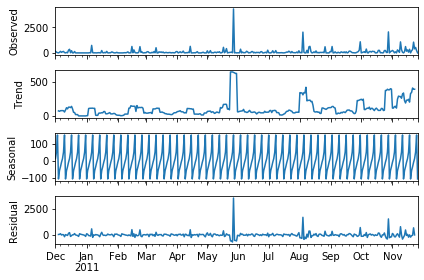

In [11]:
# visualize trend, seasonal, and random components
y = df_train_uk['DailySales']
decomp = sm.tsa.seasonal_decompose(y, model='additive', freq=7)
fig = decomp.plot()
plt.show()

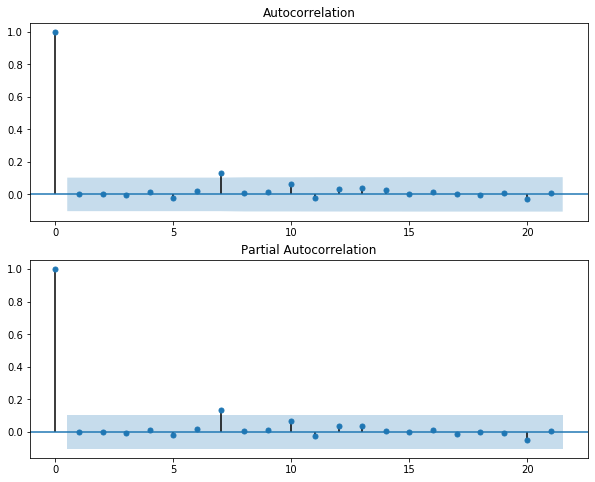

In [12]:
# check ACF and PACF
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y, lags=21, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y, lags=21, ax=ax2)

* The above plots indicate (1) stationary series, (2) 7th AR and MA lags, and (3) weekly seasonality.
* I conduct a grid search for the best seasonality parameters.

In [13]:
# set up ARIMA parameters
ar = (0,0,0,0,0,0,1)
ma = (0,0,0,0,0,0,1)

# set up seasonality parameters
p = d = q = range(0,2)
seasonal_pdq = [(x[0],x[1],x[2],52) for x in list(itertools.product(p,d,q))]

In [14]:
# grid search for the best seasonal_pdq
for param in seasonal_pdq:
    try:
        mod = sm.tsa.statespace.SARIMAX(y, order=(ar,0,ma), seasonal_order=param)
        results = mod.fit()
        print('seasonal params: ', param, ' AIC: ', results.aic)
    except:
        continue

seasonal params:  (0, 0, 0, 52)  AIC:  5164.0144674146495
seasonal params:  (0, 0, 1, 52)  AIC:  5166.002922619857
seasonal params:  (0, 1, 0, 52)  AIC:  4648.13718001856
seasonal params:  (0, 1, 1, 52)  AIC:  4528.284289444588
seasonal params:  (1, 0, 0, 52)  AIC:  5166.002869458462
seasonal params:  (1, 0, 1, 52)  AIC:  5166.634066935549
seasonal params:  (1, 1, 0, 52)  AIC:  4579.215566027675


C:\Users\User\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


seasonal params:  (1, 1, 1, 52)  AIC:  4523.535624197451


In [15]:
# fit the best SARIMA model
best_mod = sm.tsa.statespace.SARIMAX(y, order=(ar,0,ma), seasonal_order=(1,1,1,52))
results = best_mod.fit()

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


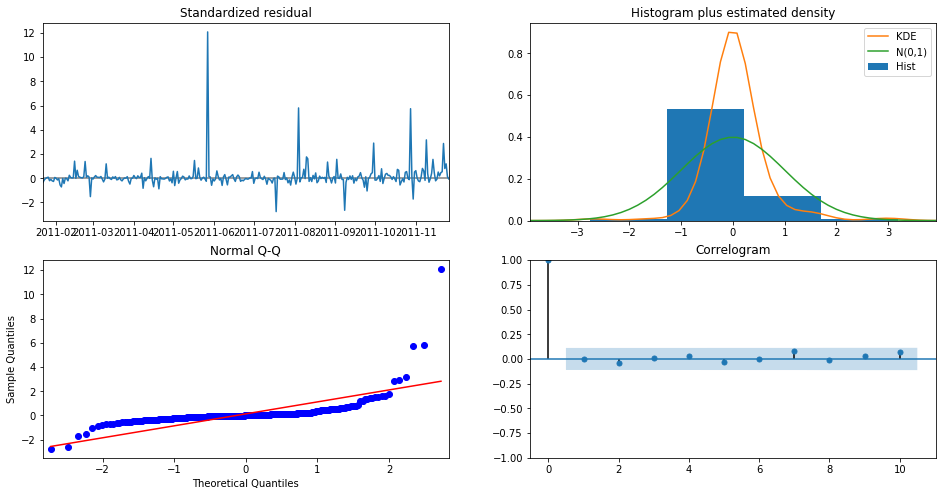

In [16]:
# SARIMA model diagnostics
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [17]:
# forecast using the best SARIMA model
pred  = results.get_prediction(start=test_start_date, end=test_end_date, dynamic=True)
yhat1 = pred.predicted_mean

### XGBoost

In [18]:
display(df_train_uk.tail(10))

,DailySales,date,Weekday,Month,Quarter
2011-11-17,72,2011-11-17,3,11,4
2011-11-18,351,2011-11-18,4,11,4
2011-11-19,0,2011-11-19,5,11,4
2011-11-20,206,2011-11-20,6,11,4
2011-11-21,326,2011-11-21,0,11,4
2011-11-22,1051,2011-11-22,1,11,4
2011-11-23,397,2011-11-23,2,11,4
2011-11-24,530,2011-11-24,3,11,4
2011-11-25,227,2011-11-25,4,11,4
2011-11-26,0,2011-11-26,5,11,4


In [19]:
# set up train and CV data for XGBoost
xtrain = df_train_uk[df_train_uk['date']<='2011-11-19']
xtrain = xtrain[['Weekday','Quarter','Month']]
ytrain = df_train_uk[df_train_uk['date']<='2011-11-19']
ytrain = ytrain['DailySales']

# use the last week (Sun-Sat) as CV data
xcv = df_train_uk[df_train_uk['date']>'2011-11-19']
xcv = xcv[['Weekday','Quarter','Month']]
ycv = df_train_uk[df_train_uk['date']>'2011-11-19']
ycv = ycv['DailySales']

In [21]:
# train and find the best XGBoost model
# use early stopping to avoid overfitting
reg = xgb.XGBRegressor()        
reg.fit(xtrain, ytrain, eval_set=[(xtrain,ytrain), (xcv,ycv)], early_stopping_rounds=10, verbose=False)

[13:45:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

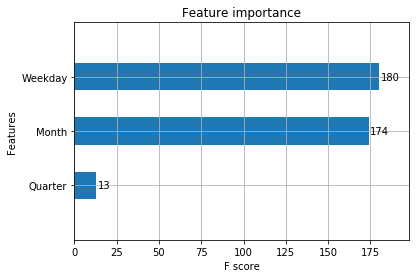

In [22]:
# feature importance
_ = plot_importance(reg, height=0.5)

In [23]:
# forecast using the XGBoost model
xtest = df_test_uk[['Weekday','Quarter','Month']]
yhat2 = reg.predict(xtest)

### Naive

In [24]:
# naive method
ytrain = df_train_uk['DailySales']
yhat_naive = [ytrain[len(ytrain)-1]] * 7
yhat_naive = pd.DataFrame(yhat_naive)
idx = pd.date_range(test_start_date, test_end_date)
yhat_naive = yhat_naive.reindex(idx, fill_value=0)

## Step 4: 
* compare all 4 models

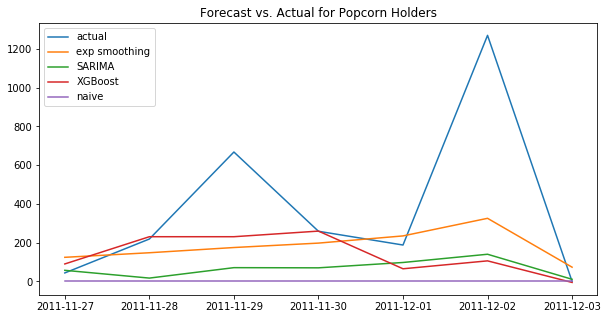

In [25]:
# actual data
ytest = df_test_uk['DailySales']

# exponential smoothing method
yhat0 = pd.DataFrame(yhat0)
yhat0['date'] = idx
yhat0 = yhat0.set_index('date')

# XGBoost method
yhat2 = pd.DataFrame(yhat2)
yhat2['date'] = idx
yhat2 = yhat2.set_index('date')

# plot forecast vs. actual
plt.figure(figsize=(10,5))
plt.plot(ytest, label='actual')
plt.plot(yhat0, label='exp smoothing')
plt.plot(yhat1, label='SARIMA')
plt.plot(yhat2, label='XGBoost')
plt.plot(yhat_naive, label='naive')
plt.title('Forecast vs. Actual for Popcorn Holders')
plt.legend(loc='best')
plt.show()

In [26]:
# compare metrics
yhat_naive = [ytrain[len(ytrain)-1]] * 7
naive_rms  = sqrt(mean_squared_error(yhat_naive, ytest))
print('naive approach RMSE:', naive_rms)

rms0 = sqrt(mean_squared_error(yhat0, ytest))
print('exp smoothing approach RMSE:', rms0)

rms1 = sqrt(mean_squared_error(yhat1, ytest))
print('SARIMA approach RMSE:', rms1)

rms2 = sqrt(mean_squared_error(yhat2, ytest))
print('XGBoost approach RMSE:', rms2)

naive approach RMSE: 562.0683740817101
exp smoothing approach RMSE: 406.60065427410007
SARIMA approach RMSE: 495.2395406033956
XGBoost approach RMSE: 472.4874620701239


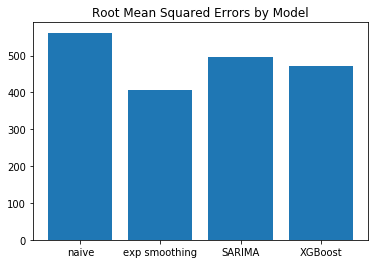

In [27]:
x = np.arange(4)
rms = [naive_rms, rms0, rms1, rms2]

fig, ax = plt.subplots()
plt.bar(x, rms)
plt.title('Root Mean Squared Errors by Model')
plt.xticks(x, ('naive', 'exp smoothing', 'SARIMA', 'XGBoost'))
plt.show()